## Problem 1: Galaxy Photometric Redshifts Continued (6 points)

In this exercise, we will return to the galaxy redshifts from problem set 4, equipped with our new tools: gradient boosting and neural networks. Here is the basic information on the data.

The file `Problem_Set_4_Redshifts.csv` contains the following data.
* `<BAND>_FLUX`: Fluxes in different bands. This is what will be used for training. Note that the data has been cleaned, and galaxies with missing fluxes have been removed.
* `Z_PHOT`: Ignore this column.
* `Z_SPEC`: These are spectroscopic redshifts $z_\mathrm{spec}$ measured from the Dark Energy Spectroscopic Instrument (DESI).

(a) Use the `sklearn.ensemble.GradientBoostingRegressor` (default parameters) and compare the feature importance to that of `sklearn.ensemble.RandomForestRegressor` (default parameters). What are the top five most important features? Are the rankings similar?

(b) Perform a $k$-fold cross-validation with $k=10$ to optimize the hyperparameters of `sklearn.ensemble.HistGradientBoostingRegressor` based on the $R^2$ score. Include (+/- 1 standard deviation) error bars derived from the scatter between different folds. For reference, the best-performing gradient boosting regressor performs at least as well as the the best random forest, i.e., $R^2 \gtrsim 0.85$. Here are a few parameters you should explore.
* `learning_rate`
* `max_iter`
* `early_stopping`
* `max_leaf_nodes`

(Tip: Use `n_jobs=-1` in `sklearn.model_selection.GridSearchCV` to parallelize cross-validation.)

(c) Repeat exercise (b) for `sklearn.neural_network.MLPRegressor`. Again, you should aim for an $R^2$ validation score of $R^2 \gtrsim 0.85$. Here are a few parameters you might vary.
* `early_stopping`
* `hidden_layer_sizes`
* `alpha`
* `activation`

I suggest you start with $3$ hidden layers of $100$ neurons each (`hidden_layer_sizes=(100, 100, 100)`). (Hint: Don't forget to scale the input features, for example, via `sklearn.preprocessing.StandardScaler`.)

Part A

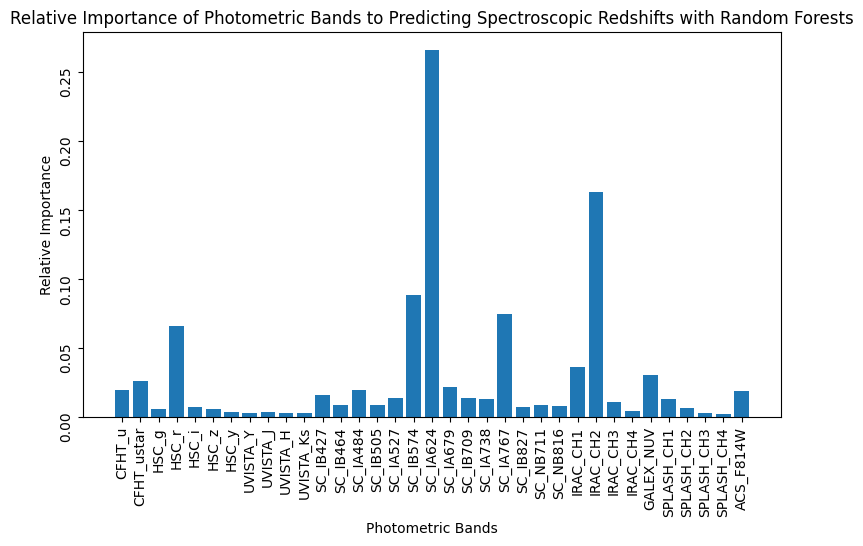

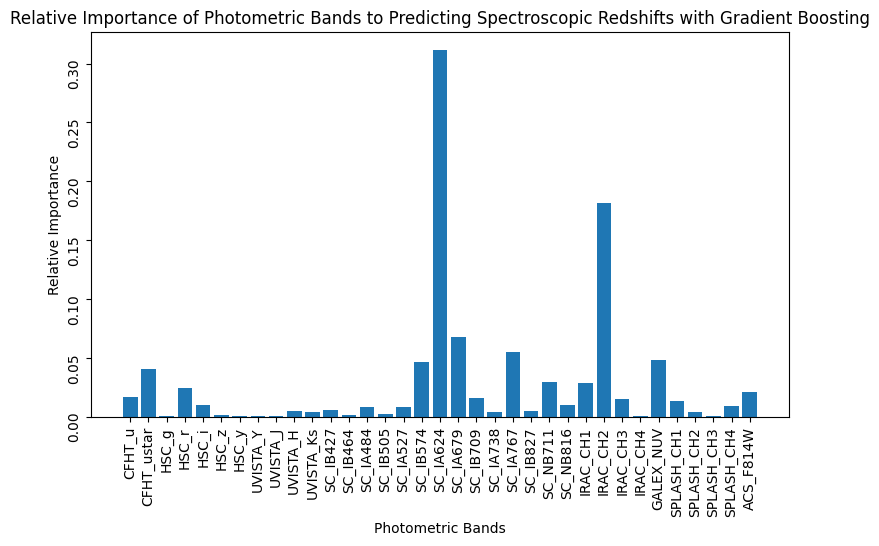

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt

df = pd.read_csv("Problem_Set_4_Redshifts.csv")
y = df["Z_SPEC"]
X = df.iloc[:, :35] # all fluxes
y_est = df["Z_PHOT"]

forest = RandomForestRegressor().fit(X, y)
gradient = GradientBoostingRegressor().fit(X, y)

# cleaning up string names
headers = []
for header in X.columns:
    new_header = header.replace("_FLUX", "")
    headers.append(new_header)

# forest plot
fig, ax = plt.subplots(figsize = (9, 5))
ax.tick_params(rotation=90)
plt.bar(headers, forest.feature_importances_)
plt.xlabel('Photometric Bands')
plt.ylabel('Relative Importance')
plt.title('Relative Importance of Photometric Bands to Predicting Spectroscopic Redshifts with Random Forests')
plt.show()

fig, ax = plt.subplots(figsize = (9, 5))
ax.tick_params(rotation=90)
plt.bar(headers, gradient.feature_importances_)
plt.xlabel('Photometric Bands')
plt.ylabel('Relative Importance')
plt.title('Relative Importance of Photometric Bands to Predicting Spectroscopic Redshifts with Gradient Boosting')
plt.show()

Random Forests: SC-IA624, IRAC-CH2, SC-IB574, SC-IA767, HSC-R

Gradient Boosting: SC-IA624, IRAC-CH2, SC-IA679, SC-IA767, GALEX-NUV

The two bands that are by far the most important (SC-IA624 and IRAC-CH2) are consistent, but the following ones vary--likely due to the inherent randomness of Random Forests.

Part B

In [2]:
import pandas as pd
from sklearn import model_selection
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np

df = pd.read_csv("Problem_Set_4_Redshifts.csv")
y = df["Z_SPEC"]
X = df.iloc[:, :35] # all fluxes
y_est = df["Z_PHOT"]

k_num = 10
kfold = model_selection.KFold(n_splits=k_num, shuffle=True)

param_grid = dict(early_stopping = [True, False],
                  learning_rate = np.linspace(0.3, 0.5, num=5),
                  max_iter = [5, 7, 9],
                  max_leaf_nodes = [30, 40, 50])
model_search = model_selection.GridSearchCV(HistGradientBoostingRegressor(), param_grid=param_grid, cv=kfold, scoring = "r2", n_jobs=-1)
model_search.fit(X, y)

print(f"Best Params: {model_search.best_params_}\nBest R2 Score: {model_search.best_score_}")

df = pd.DataFrame(model_search.cv_results_)
results = df.rename(columns={f'param_{param}' : param for param in param_grid.keys()})
results = results[[param for param in param_grid.keys()] + ['mean_test_score', 'rank_test_score', 'std_test_score']]
results = results.sort_values(by='rank_test_score')
display(results)


Best Params: {'early_stopping': False, 'learning_rate': np.float64(0.4), 'max_iter': 9, 'max_leaf_nodes': 50}
Best R2 Score: 0.8723768046479995


,early_stopping,learning_rate,max_iter,max_leaf_nodes,mean_test_score,rank_test_score,std_test_score
71,False,0.40,9,50,0.872377,1,0.022445
62,False,0.35,9,50,0.871334,2,0.022733
17,True,0.35,9,50,0.870846,3,0.024315
35,True,0.45,9,50,0.869332,4,0.023809
68,False,0.40,7,50,0.867773,5,0.023013
...,...,...,...,...,...,...,...
54,False,0.35,5,30,0.819804,86,0.020477
46,False,0.30,5,40,0.814336,87,0.022064
1,True,0.30,5,40,0.813560,88,0.023817
0,True,0.30,5,30,0.801005,89,0.024039


Part C

In [3]:
import pandas as pd
from sklearn import model_selection
from sklearn.neural_network import MLPRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("Problem_Set_4_Redshifts.csv")
y = df["Z_SPEC"].to_numpy()
X = df.iloc[:, :35] # all fluxes
y_est = df["Z_PHOT"]

X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y.reshape(-1, 1)).flatten()

k_num = 10
kfold = model_selection.KFold(n_splits=k_num, shuffle=True)

param_grid = dict(early_stopping = [True, False],
                  alpha = np.linspace(0, 0.1, num=5),
                  hidden_layer_sizes = [[100, 100, 100]],
                  activation = ['relu', 'tanh'],)
model_search = model_selection.GridSearchCV(MLPRegressor(), param_grid=param_grid, cv=kfold, scoring = "r2", n_jobs=-1)
model_search.fit(X, y)

print(f"Best Params: {model_search.best_params_}\nBest R2 Score: {model_search.best_score_}")

df = pd.DataFrame(model_search.cv_results_)
results = df.rename(columns={f'param_{param}' : param for param in param_grid.keys()})
results = results[[param for param in param_grid.keys()] + ['mean_test_score', 'rank_test_score', 'std_test_score']]
results = results.sort_values(by='rank_test_score')
display(results)

Best Params: {'activation': 'relu', 'alpha': np.float64(0.0), 'early_stopping': False, 'hidden_layer_sizes': [100, 100, 100]}
Best R2 Score: 0.9028182744556744


,early_stopping,alpha,hidden_layer_sizes,activation,mean_test_score,rank_test_score,std_test_score
1,False,0.000,"[100, 100, 100]",relu,0.902818,1,0.024626
5,False,0.050,"[100, 100, 100]",relu,0.902407,2,0.025513
11,False,0.000,"[100, 100, 100]",tanh,0.902270,3,0.028209
9,False,0.100,"[100, 100, 100]",relu,0.898743,4,0.027206
13,False,0.025,"[100, 100, 100]",tanh,0.894662,5,0.030590
8,True,0.100,"[100, 100, 100]",relu,0.892548,6,0.027795
3,False,0.025,"[100, 100, 100]",relu,0.892202,7,0.042806
2,True,0.025,"[100, 100, 100]",relu,0.891937,8,0.035085
10,True,0.000,"[100, 100, 100]",tanh,0.891888,9,0.031968
7,False,0.075,"[100, 100, 100]",relu,0.890747,10,0.048577
